# Performance comparison of inference on dyngen data

Notebook compares metrics for velocity, latent time and GRN inference across different methods applied to dyngen-generated data.

## Library imports

In [1]:
import pandas as pd
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.core import METHOD_PALETTE
from rgv_tools.plotting._significance import add_significance, get_significance

## General settings

In [2]:
DATASET = "dyngen"

In [3]:
SAVE_FIG = True
if SAVE_FIG:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

## Constants

In [4]:
VELOCITY_METHODS = ["regvelo", "velovi", "scvelo", "unitvelo", "velovae_vae", "velovae_fullvb", "tfvelo", "cell2fate"]
TIME_METHODS = ["regvelo", "velovi", "scvelo", "unitvelo", "velovae_vae", "velovae_fullvb", "tfvelo", "cell2fate"]
GRN_METHODS = ["regvelo", "correlation", "grnboost2", "celloracle", "tfvelo", "splicejac"]

## Data loading

In [5]:
correlation_df = []
grn_df = []

for method in VELOCITY_METHODS:
    df = pd.read_parquet(DATA_DIR / DATASET / "results" / f"{method}_correlation.parquet")
    df.columns = f"{method}_" + df.columns
    correlation_df.append(df)

for method in GRN_METHODS:
    df = pd.read_parquet(DATA_DIR / DATASET / "results" / f"{method}_correlation.parquet")
    df.columns = f"{method}_" + df.columns
    grn_df.append(df)

In [6]:
correlation_df = pd.concat(correlation_df, axis=1)
grn_df = pd.concat(grn_df, axis=1)

## Analysis

### Velocity

In [7]:
default_color = "#949494"
# Update METHOD_PALETTE with new methods if not present
for method in [method for method in VELOCITY_METHODS if method not in METHOD_PALETTE]:
    METHOD_PALETTE.setdefault(method, default_color)

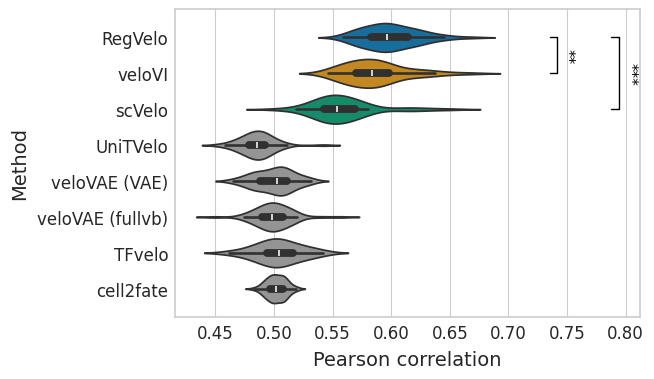

In [8]:
df = correlation_df.loc[:, correlation_df.columns.str.contains("velocity")]
df.columns = df.columns.str.removesuffix("_velocity")
df = pd.melt(df, var_name="method", value_name="correlation")
df["correlation"] = (df["correlation"] + 1) / 2

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.violinplot(
        data=df, x="correlation", y="method", hue="method", order=VELOCITY_METHODS, palette=METHOD_PALETTE, ax=ax
    )

    ttest_res = ttest_ind(
        correlation_df["regvelo_velocity"],
        correlation_df["velovi_velocity"],
        equal_var=False,
        alternative="greater",
    )
    significance = get_significance(pvalue=ttest_res.pvalue)
    add_significance(
        ax=ax,
        left=0,
        right=1,
        significance=significance,
        lw=1,
        bracket_level=1.05,
        c="k",
        level=0,
        orientation="vertical",
    )

    ttest_res = ttest_ind(
        correlation_df["velovi_velocity"],
        correlation_df["scvelo_velocity"],
        equal_var=False,
        alternative="greater",
    )
    significance = get_significance(pvalue=ttest_res.pvalue)
    add_significance(
        ax=ax,
        left=0,
        right=2,
        significance=significance,
        lw=1,
        bracket_level=1.05,
        c="k",
        level=0,
        orientation="vertical",
    )

    ax.set(
        xlabel="Pearson correlation",
        ylabel="Method",
        yticks=ax.get_yticks(),
        yticklabels=[
            "RegVelo",
            "veloVI",
            "scVelo",
            "UniTVelo",
            "veloVAE (VAE)",
            "veloVAE (fullvb)",
            "TFvelo",
            "cell2fate",
        ],
    )

    if SAVE_FIG:
        fig.savefig(
            FIG_DIR / DATASET / "velocity_benchmark.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )

    plt.show()

### GRN

In [9]:
default_color = "#949494"
# Update METHOD_PALETTE with new methods if not present
for method in [method for method in GRN_METHODS if method not in METHOD_PALETTE]:
    METHOD_PALETTE.setdefault(method, default_color)

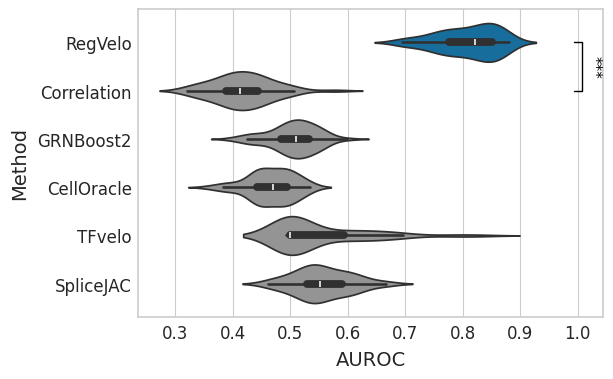

In [10]:
df = grn_df.loc[:, grn_df.columns.str.contains("grn")]
df.columns = df.columns.str.removesuffix("_grn")
df = pd.melt(df, var_name="method").rename(columns={"value": "correlation"})

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.violinplot(data=df, x="correlation", y="method", hue="method", order=GRN_METHODS, palette=METHOD_PALETTE, ax=ax)

    ttest_res = ttest_ind(
        grn_df["regvelo_grn"],
        grn_df["correlation_grn"],
        equal_var=False,
        alternative="greater",
    )
    significance = get_significance(pvalue=ttest_res.pvalue)
    add_significance(
        ax=ax,
        left=0,
        right=1,
        significance=significance,
        lw=1,
        bracket_level=1.05,
        c="k",
        level=0,
        orientation="vertical",
    )

    ax.set(
        xlabel="AUROC",
        ylabel="Method",
        yticks=ax.get_yticks(),
        yticklabels=["RegVelo", "Correlation", "GRNBoost2", "CellOracle", "TFvelo", "SpliceJAC"],
    )

    if SAVE_FIG:
        fig.savefig(
            FIG_DIR / DATASET / "grn_benchmark.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )

    plt.show()